# Fill in outs 
## June

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os


from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'


## We don't know now many outs there are at any point!

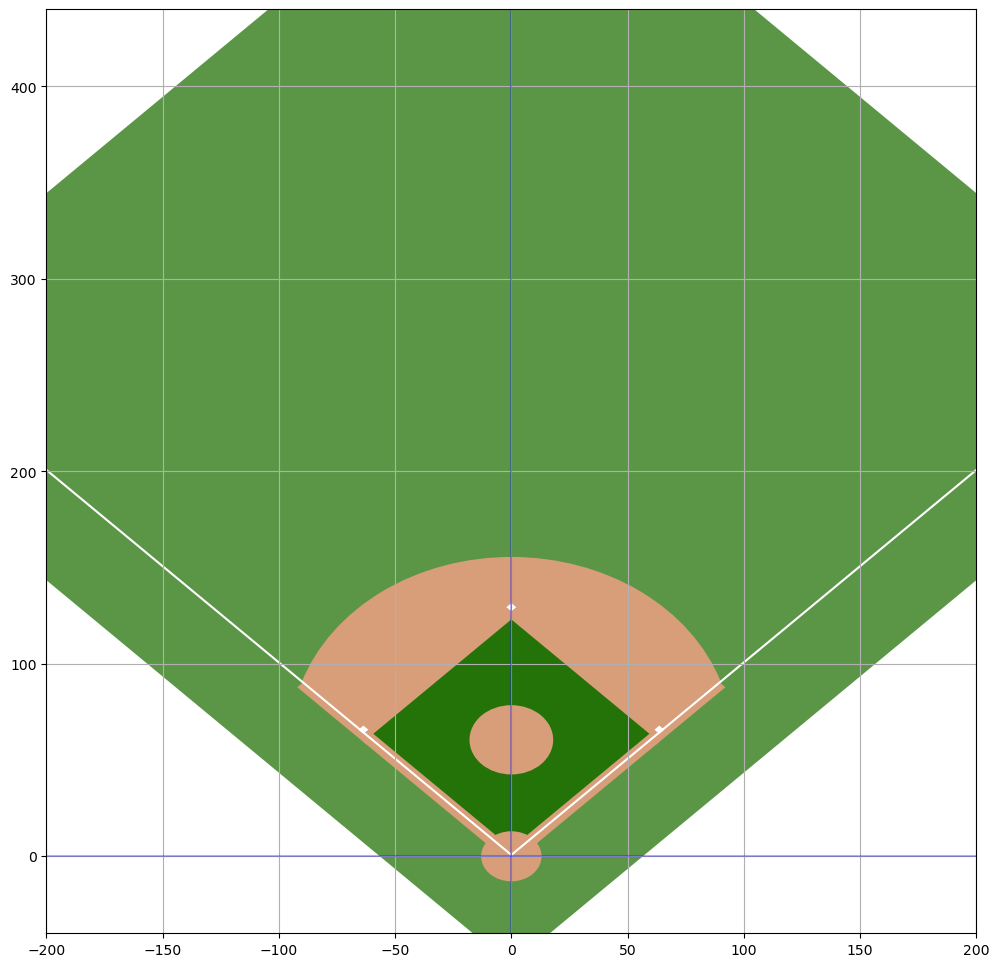

In [3]:
bf_1903_30 = Baseball_Field("1903_30_TeamNB_TeamA1")

In [4]:
first_two_innings = bf_1903_30.game_obj.game_info_df.loc[(bf_1903_30.game_obj.game_info_df["inning"].isin([1, 2])), :].copy()

first_two_innings["prev_outs"] = np.nan
first_two_innings["this_play_outs"] = np.nan


first_two_innings["n_br"] = first_two_innings[["first_baserunner", "second_baserunner", "third_baserunner"]].apply(lambda row: sum(row.apply(lambda x: 0 if x == 0 else 1)), axis=1)



In [5]:
hr_indices = bf_1903_30.game_obj.game_events_df["event"] == "home run"

# the number of outs but be the same as before

In [6]:
# I think I want to track guesses like sudoku here
# I think that gets done recursively and is like O(n^3)?



candidate_n_outs = dict((el, [0, 1, 2]) for el in first_two_innings.index)


In [7]:
# you know for certain that there are no outs when it is the first batter in the half inning
switiching_sides_indices = first_two_innings.loc[first_two_innings["top_bottom_inning"].shift() != first_two_innings["top_bottom_inning"]].index

for i in switiching_sides_indices:
    candidate_n_outs[i] = [0]


first_two_innings.loc[switiching_sides_indices, "prev_outs"] = 0
#first_two_innings.loc[switiching_sides_indices, "this_play_outs"] = 0


In [8]:
first_two_innings.loc[12:30, :]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
12,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,12,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,NaN,0
13,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,13,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
14,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,14,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
15,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,15,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
16,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,16,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
17,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,17,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,NaN,NaN,0
18,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,18,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,NaN,NaN,1
19,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,19,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,NaN,NaN,1
20,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,20,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,NaN,NaN,1
21,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,21,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,2919,0,NaN,NaN,1


## Lean full into the Sudoku solver strategy


At a high level, I think I need:
- a recursive function that returns true or false
    - a for loop from 0, 2 (inclusive)
- a thing that finds an empty cell
- an "is_valid_outs" function where I enumerate all of my rules


### I think I want to keep the half inning df, but pass around the sequences!

In [9]:
def solve_outs_sequence_seq(half_inning_df, seq):
    
    empty_cell_index = find_empty_cell_seq(seq)
    
    if empty_cell_index is None:
        # you have found a valid solution and this is what makes your thing return
        return True
    
    
    for this_play_outs in range(3):
        
        # print("print looking at ", this_play_outs)

        
        if is_valid_outs_assignment_seq(half_inning_df, seq, this_play_outs, empty_cell_index):
            seq[empty_cell_index, 1] = this_play_outs
            
            temp_sum = 0 if empty_cell_index == 0 else sum(seq[empty_cell_index - 1, :])
            
            seq[empty_cell_index, 0] = temp_sum
            
            pass
            
           # half_inning_df.loc[empty_cell_index, "this_play_outs"] = this_play_outs
           # half_inning_df.loc[empty_cell_index, "prev_outs"] = half_inning_df.loc[empty_cell_index - 1, ["this_play_outs", "prev_outs"]].sum()
            
            
            if solve_outs_sequence_seq(half_inning_df, seq):
                # you did it!
                return True
        
            seq[empty_cell_index, 0] = np.nan
            seq[empty_cell_index, 1] = np.nan
            
    return False


def find_empty_cell_seq(seq):
    
    #seq = half_inning_df["this_play_outs"] 
    
    index = None
    
    # this play outs is in the second column!
    
    for i, val in enumerate(seq[:, 1]):
        if np.isnan(val):
            return i
    
    return index


def is_valid_outs_assignment_seq(half_inning_df, seq, this_play_outs, empty_cell_index):
    
    all_batting_team = ["batter", "first_baserunner", "second_baserunner", "third_baserunner"]
    all_br = ["first_baserunner", "second_baserunner", "third_baserunner"]
    
    seq_len = seq.shape[0]
    
    # debugging
    
    this_row = half_inning_df.iloc[empty_cell_index]
    
    old_set_batting_team = set()
    prev_total_outs = 0
    
    if empty_cell_index != 0:
        # you need to set and check all of the things that look at the prev row 
        old_set_batting_team = set(half_inning_df.iloc[empty_cell_index - 1][all_batting_team])
        prev_total_outs = sum(seq[empty_cell_index - 1, :])
          
    next_batter = None
    next_set_batting_team = set()
    next_set_br = set()


    if empty_cell_index < seq_len - 1:
        next_batter = half_inning_df.iloc[empty_cell_index + 1]["batter"]
        next_set_batting_team = set(half_inning_df.iloc[empty_cell_index + 1][all_batting_team])
        next_set_br = set(half_inning_df.iloc[empty_cell_index + 1][all_br])
    
    this_batter = half_inning_df.iloc[empty_cell_index]["batter"]
    this_set_br = set(half_inning_df.iloc[empty_cell_index][all_br])
    
    
    same_batter_next_play = this_batter == next_batter
    
    # Outs has to be the same or more as all previous indices in the sequence
    this_set_batting_team = set(half_inning_df.iloc[empty_cell_index][all_batting_team])
        
    
    does_this_make_3 = prev_total_outs + this_play_outs
    
    ## end debugging
    
    pass
    
    # Assuming consecutive indices!

    
    # TODO: 
    # It can't be an out if the batter is on base next play and a runner scores
    



    if this_play_outs == 0 and this_batter not in next_set_br \
        and this_batter != next_batter:
        # if the batter is not on the bases when there is a new batter and it wasn't a HR then someone got out:
    
        return False
    
    
    # TODO:
    # It can't be more than one out if an outfielder catches the ball and doesn't throw it?
    
    
        
    if this_play_outs != 1 and set([br for br in this_set_br if br != 0 ]) == set([br for br in next_set_br if br != 0 ]) \
        and this_batter != next_batter:
        # TODO:
        # It must be 1 out if there are non zero BRs that stay the same, and there is a new batter -- this is a strikeout
        # Assumption this goes wrong for mid at bat PH, but that might be rare -- ignore that
        
        return False
    
    
    if this_play_outs != 0 and this_set_batting_team == next_set_batting_team:
    # Outs can't go up is there is the same batter and baserunners
        return False
    
    
    if this_play_outs > (1 + half_inning_df.iloc[empty_cell_index]["n_br"]):
        # Outs can't go up by more than the number of baserunners + 1
        return False
    
    if this_play_outs != 0 \
        and next_set_br == this_set_batting_team:
        # and half_inning_df.iloc[empty_cell_index - 1]["batter"] != 0\ # not sure about this part
        
            # Outs can't go up if the batter becomes the baserunner on the next play 
            # and the previous set of baserunners is still there

            return False
    
    
    if this_play_outs != 0 and half_inning_df.iloc[empty_cell_index]["play_per_game"] \
        in bf_1903_30.game_obj.game_events_df.loc[hr_indices, "play_per_game"]:
        # Outs can't go up on a home run
        return False
    
    
    
    if this_play_outs != 0 and len(this_set_batting_team) == 2 and same_batter_next_play:
        # Outs can't go up if there are no baserunners and the batter is the same in the next play
        # len(this_set_batting_team) == 2 is because the set will be batter_num and 0
    
        return False
        
    
    
    if ((seq_len - 1) == (empty_cell_index)) \
        and (does_this_make_3 != 3):
        # if we are on the last index, then this_play_outs and prev_outs must sum to three
        
        return False

    
    
    
    return True



    
    

#### Test case on an obviously 1-2-3 inning

In [10]:
first_half = first_two_innings.loc[(first_two_innings["inning"] == 1) & (first_two_innings["top_bottom_inning"] == "Top") , :]

outs_seq = first_half[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(first_half, outs_seq)

print(outs_seq)

[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [11]:
first_half.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq

In [12]:
first_half

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
1,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,1,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
2,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,2,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,0.0,0
3,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,1,3,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,6189,0,0,0,0.0,1.0,0
4,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,4,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
5,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,5,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
6,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,6,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,0.0,0
7,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,2,7,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8638,0,0,0,1.0,1.0,0
8,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,8,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,0.0,0
9,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,9,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,0.0,0
10,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,3,10,1,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,3718,0,0,0,2.0,0.0,0


### Bottom of the first
#### this one seems harder, because there are baserunners, etc

- if something is wrong on this, I think the plan will be to check things like throws and balls acquired, etc


In [13]:
bottom_first = first_two_innings.loc[(first_two_innings["inning"] == 1) & (first_two_innings["top_bottom_inning"] == "Bottom") , :]

outs_seq = bottom_first[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(bottom_first, outs_seq)

print(outs_seq)


[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [14]:
bottom_first.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_first


,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
12,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,12,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
13,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,13,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
14,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,14,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
15,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,15,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
16,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,16,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
17,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,4,17,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2919,0,0,0,0.0,0.0,0
18,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,18,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,0.0,0.0,1
19,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,19,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,0.0,0.0,1
20,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,20,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,2919,0,0,0.0,0.0,1
21,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,5,21,1,Bottom,8713,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,2919,0,0.0,0.0,1


##### Description of bottom of the first

Brainstorming on how where this is wrong, and what could be done to make it work better
- I think "baserunner scores" could be something?

A description of what is going on rn:

- 20 is an advancement on a passed ball or wild pitch
- 22 is a single that moves the runner to single I think -- its actually a fielding error lol
- 27 is another advancement on a passed ball or wild pitch
- 29 is this an RBI ground out that gets called safe?


- 34 is a single to right, with the runner on third scoring
- 39 is a walk or right?
- 43 is another walk? it was wayyyy outside lol
- 46 should have been a strikeout I think? --- COME UP WITH A STRIKEOUT RULE? Maybe if there is a new batter, and all the br stay the same -- this goes wrong for mid at bat PH, but that might be rare -- 
- 51 is a walk that gets marked a strikeout -- FIX HERE -- It can't be an out if that batter it on base next play
- 56 is a flyout to center field, -- FIX HERE -- it is only one out! 

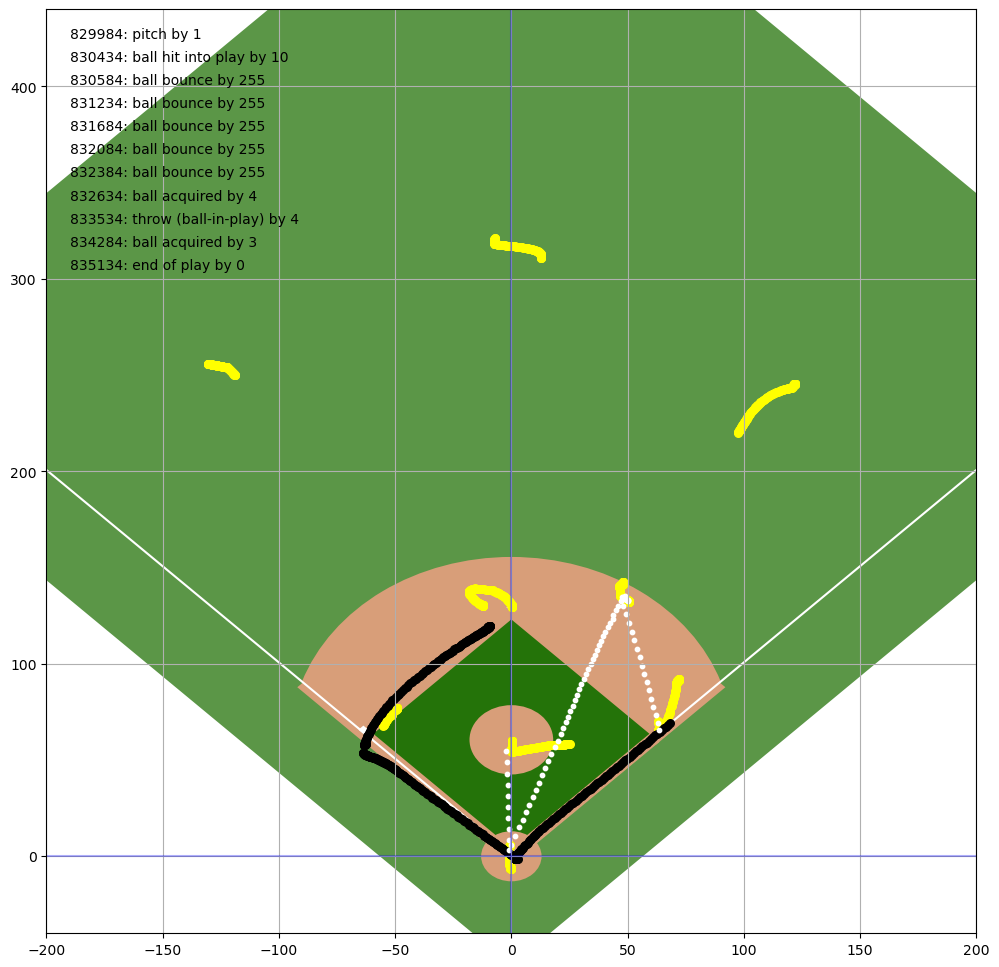

In [15]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(29)

bf_1903_30.plot_all_components(play_id=play_id)

bf_1903_30.fig
# bf_1903_30.create_gif(play_id=play_id, tag="--is this a dp")

### Top of the second

In [16]:

top_second = first_two_innings.loc[(first_two_innings["inning"] == 2) & (first_two_innings["top_bottom_inning"] == "Top") , :]

outs_seq = top_second[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(top_second, outs_seq)

print(outs_seq)


[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [17]:
top_second.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
top_second

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
57,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,57,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
58,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,58,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
59,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,59,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
60,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,60,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
61,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,61,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,0.0,0
62,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,14,62,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,5291,0,0,0,0.0,1.0,0
63,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,63,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,1.0,0.0,0
64,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,64,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,1.0,0.0,0
65,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,15,65,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,4794,0,0,0,1.0,1.0,0
66,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,16,66,2,Top,2145,1945,1286,2919,1771,2148,1973,2766,1185,8079,0,0,0,2.0,0.0,0


##### Top of second description

A description of what is going on rn:

- 62 was a 4-3 put out
- 65 is a 6-3 put out
- 69 is a dropped third strike lol
- 75 is 6 unassisted

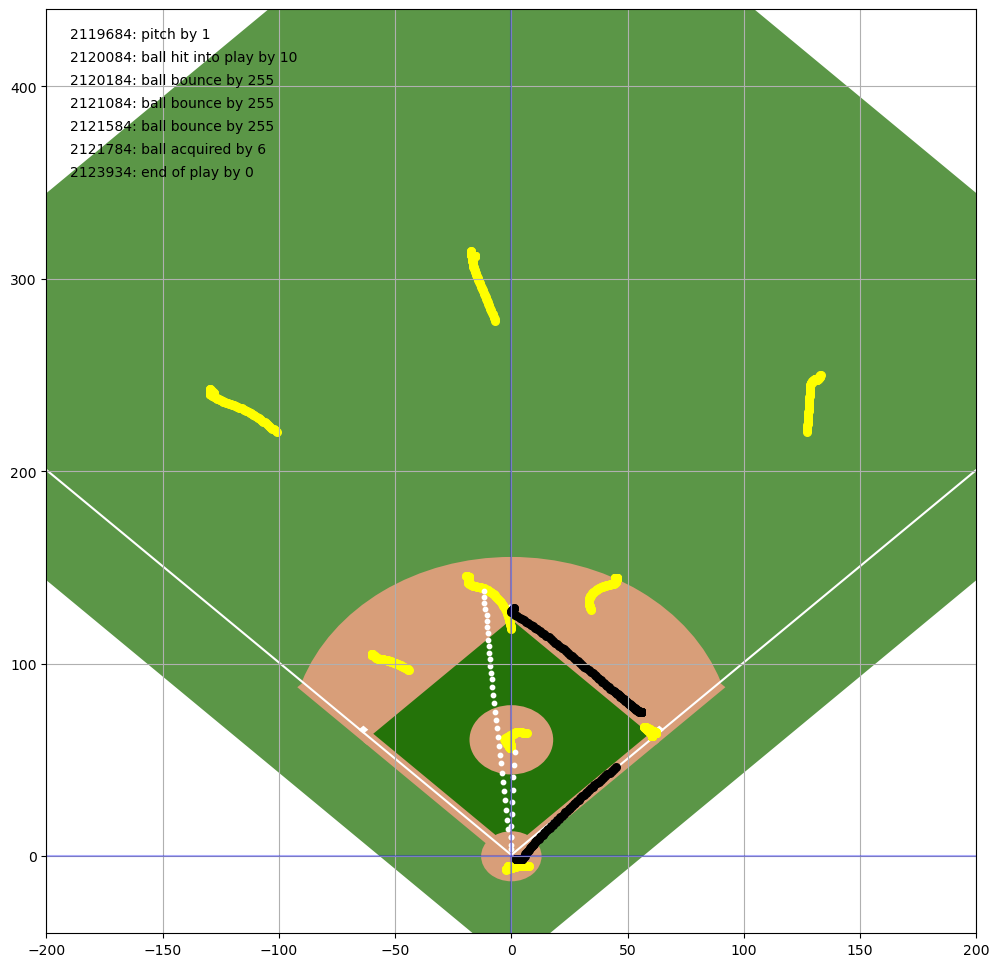

In [18]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(75)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--6_unassisted")

### Bottom of the second

In [19]:

bottom_second = first_two_innings.loc[(first_two_innings["inning"] == 2) & (first_two_innings["top_bottom_inning"] == "Bottom") , :]

outs_seq = bottom_second[["prev_outs", "this_play_outs"]].copy().values

print(outs_seq)

solve_outs_sequence_seq(bottom_second, outs_seq)

print(outs_seq)


[[ 0. nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [2. 0.]
 [2. 0.]
 [2. 1.]]


In [20]:
bottom_second.loc[:, ["prev_outs", "this_play_outs"]] = outs_seq
bottom_second

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,prev_outs,this_play_outs,n_br
76,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,18,76,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2766,0,0,0,0.0,0.0,0
77,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,19,77,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,2766,0,0,0.0,0.0,1
78,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,19,78,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1973,2766,0,0,0.0,0.0,1
79,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,20,79,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1185,0,1973,2766,0.0,0.0,2
80,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,80,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
81,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,81,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
82,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,82,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
83,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,21,83,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,1945,0,0,1185,0.0,0.0,1
84,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,22,84,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,1185,0.0,0.0,2
85,1903_30_TeamNB_TeamA1,TeamA1,TeamNB,22,85,2,Bottom,9111,3718,6789,6189,3363,8079,8638,5291,3291,2386,1945,0,1185,0.0,1.0,2


##### Bottom of second description

A description of what is going on rn:

- 76 is a HBP lol that it counts as a ball deflection
- 78 is a double to left field
- 79 is a triple off the right center wall
- 83 is a walk
- 85 is a sac fly to center
- 87 is a 1-3 sacrifice?
- 90 is a lazy fly to left



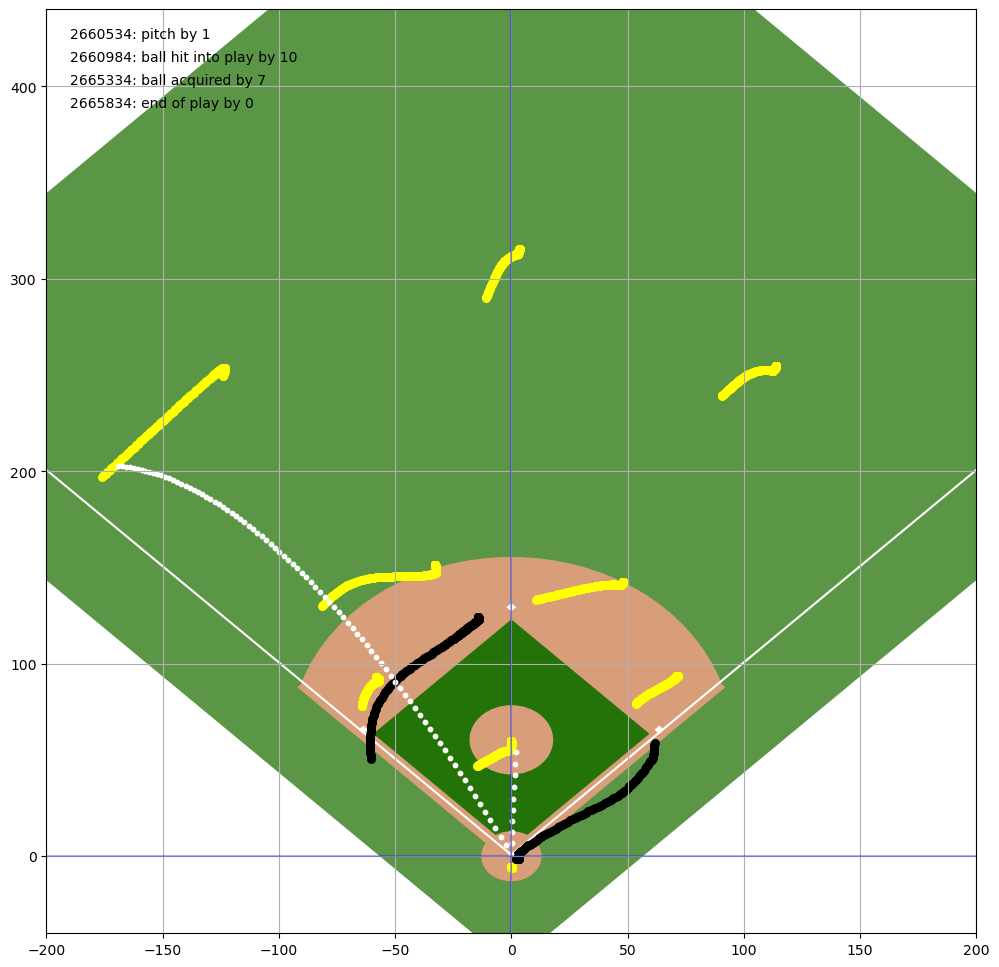

In [21]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(90)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")

### The first two innings worked -- I am convinced that it works for now
 
- Make this as module in Game class
- Add a tiny score bug? or like a number of outs bug to plot? Maybe next time I go under the hood there
